# Personal Key Indicators for Heart Disease
#### Importing libraries\Loading Dataset

In [1]:
# Importing relevant libraries
import re
import gc
import time
import json
import codecs, json 
import contextlib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import category_encoders as ce
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler

# featuretools for automated feature engineering
import featuretools as ft

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset
dataset = pd.read_csv('data/heart_2020_cleaned.csv')

#### Profile Reporting

In [2]:
# # Profiling the dataset
profile = ProfileReport(dataset, title='Profiling Report Dataset')
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

#### Description

In [3]:
# Slicing the dataset to first 10000 rows, since the data is huge
# dataset = dataset.iloc[:500]

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [4]:
dataset.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [5]:
dataset.describe(include='all')

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795,319795.000000,319795,319795,319795,319795.00000,319795.000000,319795,319795,319795,319795,319795,319795,319795,319795.000000,319795,319795,319795
unique,2,NaN,2,2,2,NaN,NaN,2,2,13,6,4,2,5,NaN,2,2,2
top,No,NaN,No,No,No,NaN,NaN,No,Female,65-69,White,No,Yes,Very good,NaN,No,No,No
freq,292422,NaN,187887,298018,307726,NaN,NaN,275385,167805,34151,245212,269653,247957,113858,NaN,276923,308016,289976
mean,NaN,28.325399,NaN,NaN,NaN,3.37171,3.898366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.097075,NaN,NaN,NaN
std,NaN,6.356100,NaN,NaN,NaN,7.95085,7.955235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436007,NaN,NaN,NaN
min,NaN,12.020000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,24.030000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN
50%,NaN,27.340000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN
75%,NaN,31.420000,NaN,NaN,NaN,2.00000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN


## Data Transformation

#### Encoding Dataset

In [6]:
binary_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
               'Sex', 'PhysicalActivity', 'Asthma', 'SkinCancer']
onehot_cols = ['Race', 'KidneyDisease', 'GenHealth', 'Diabetic']
scale_cols = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

# Separating target from features
features = dataset.drop(columns='HeartDisease')     # X
target = dataset['HeartDisease']                    # y

# Encoding target variable with LabelEncoder
label_encoder = preprocessing.LabelEncoder()
target = label_encoder.fit_transform(target)

# Encoding binary_cols with BinaryEncoder
binary_encoder = ce.BinaryEncoder(cols=binary_cols)
binary_encoded = binary_encoder.fit_transform(features[binary_cols])
features = features.drop(columns=binary_cols)
features = pd.concat([features, binary_encoded], axis=1)

# Encoding onehot_cols with OneHotEncoder
onehot_encoder = preprocessing.OneHotEncoder()
onehot_encoded = pd.DataFrame(onehot_encoder.fit_transform(features[onehot_cols]).toarray(), columns=onehot_encoder.get_feature_names_out(onehot_cols))
features = features.drop(columns=onehot_cols)
features = features.join(onehot_encoded)

# Encoding scale_cols with MaxAbsScaler
scale_encoder = MaxAbsScaler()
features[scale_cols] = scale_encoder.fit_transform(features[scale_cols])

# Encoding AgeCategory as a continuous variable
AgeCategory_encoded = {'55-59': 57, '80 or older': 80, '65-69': 67,
                       '75-79': 77, '40-44': 42, '70-74': 72, '60-64': 62,
                       '50-54': 52, '45-49': 47, '18-24': 21, '35-39': 37,
                       '30-34': 32, '25-29': 27}
dataset['AgeCategory'] = dataset['AgeCategory'].apply(
    lambda x: AgeCategory_encoded[x])
features['AgeCategory'] = dataset['AgeCategory'].astype('float')

# Removing any string inconsistencies in the dataframe headers
features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#### Train and Test Split

In [7]:
# Performing the split here
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42, stratify=target)

#### Dataset Balancing

Before balancing the data:


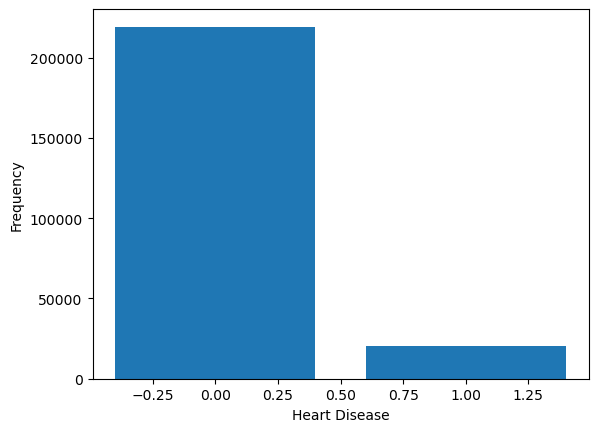

In [8]:
# Viewing distribution of yes and no values in the target column
print("Before balancing the data:")
class_dist2 = pd.Series(y_train).value_counts()
plt.bar(class_dist2.index, class_dist2)
plt.ylabel("Frequency")
plt.xlabel("Heart Disease")
plt.show()

After balancing the data:


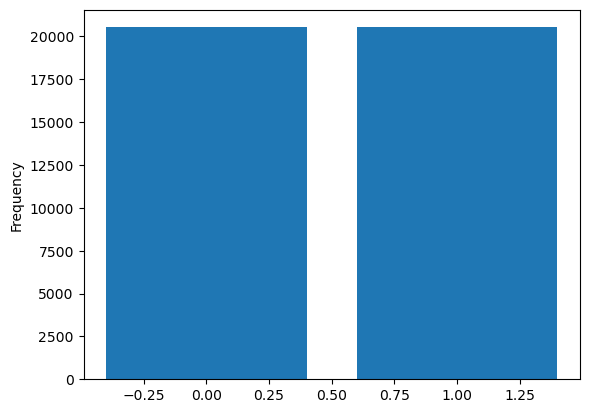

In [9]:
# Undersample the training data
sampler = RandomUnderSampler(random_state=42)
balanced_X_train, balanced_y_train = sampler.fit_resample(
    X_train, y_train)

# Viewing distribution of yes and no values in the target column after balancing the data
print("After balancing the data:")
class_dist2 = pd.Series(balanced_y_train).value_counts()
plt.bar(class_dist2.index, class_dist2)
plt.ylabel("Frequency")
plt.show()

In [10]:
balanced_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41060 entries, 0 to 41059
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BMI                               41060 non-null  float64
 1   PhysicalHealth                    41060 non-null  float64
 2   MentalHealth                      41060 non-null  float64
 3   AgeCategory                       41060 non-null  float64
 4   SleepTime                         41060 non-null  float64
 5   Smoking_0                         41060 non-null  int64  
 6   Smoking_1                         41060 non-null  int64  
 7   AlcoholDrinking_0                 41060 non-null  int64  
 8   AlcoholDrinking_1                 41060 non-null  int64  
 9   Stroke_0                          41060 non-null  int64  
 10  Stroke_1                          41060 non-null  int64  
 11  DiffWalking_0                     41060 non-null  int64  
 12  Diff

# Evaluation

### Model
It returns values for the following metrics:
1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Kappa Score: we initially agreed in eliminating this. But I read in an article that Kappa score is a better indicator of multidimensional data.

In [11]:
# Create a function for the model evaluation process
def evaluate_model(model, X_test, y_test):

    # Predict Test Data
    y_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

#### This function is where the magic happens.

In [12]:
# Create a single function for all classifiers to minimize LOC
def run_classifier(estimator, parameters={}):
    # Identify estimator being used
    print("Classifier: " + str(estimator).split('(')[0])
    
    # Start timer
    tic = time.perf_counter()

    # Create grid search instance
    cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search_estimator = GridSearchCV(estimator, parameters, scoring='recall', n_jobs=10, cv=cross_val)

    # Apply nested cross validation
    nested_cv_score = cross_val_score(grid_search_estimator, balanced_X_train, balanced_y_train, cv=5, scoring='recall', n_jobs=10)
    print('Nested Cross Validation Score: ' + str(nested_cv_score.mean()))

    # Fit the estimator
    grid_search_estimator.fit(balanced_X_train, balanced_y_train)
    print('Best Parameters are: ' + str(grid_search_estimator.best_params_))

    # Create a prediction
    prediction = grid_search_estimator.predict(X_test)

    # Evaluate model
    evaluation = evaluate_model(grid_search_estimator, X_test, y_test)

    # Append estimator and evaluation as dictionary pairs
    est_eval.update({estimator: evaluation})

    # Save results to a text file to make future result imports easy
    file_path = 'nonfs-evaluation-' + str(estimator).split('(')[0] + '.txt'
    with open(file_path, "w") as o:
        with contextlib.redirect_stdout(o):
            print(evaluation)

    # Print result
    print('Accuracy:', evaluation['acc'])
    print('Precision:', evaluation['prec'])
    print('Recall:', evaluation['rec'])
    print('F1 Score:', evaluation['f1'])
    print('Kappa Score:', evaluation['kappa'])
    print('Area Under Curve:', evaluation['auc'])
    print('Confusion Matrix:\n', evaluation['cm'])

    # End timer
    toc = time.perf_counter()
    print(f"Finished processing {str(estimator).split('(')[0]} in {toc - tic:0.4f} seconds")
    print("=====================================================")

## Hyperparameter Tuning

In [13]:
# Create a dictionary of estimators and their respective evaluations
est_eval = {}

### Naive Bayes

In [14]:
# Create estimator
estimator = GaussianNB()

# Printing output to a file using contextlib
file_path = 'nonfs-metric-scores-' + str(estimator).split('(')[0] + '.txt'
with open(file_path, "w") as o:
    with contextlib.redirect_stdout(o):
        
        # Specify parameter grid or distribution
        parameters = {
            }
        run_classifier(estimator, parameters)

### Decision Tree

In [15]:
# Create estimator
estimator = DecisionTreeClassifier(random_state=42)

# Printing output to a file using contextlib
file_path = 'nonfs-metric-scores-' + str(estimator).split('(')[0] + '.txt'
with open(file_path, "w") as o:
    with contextlib.redirect_stdout(o):
        
        # specify parameter grid or distribution
        parameters = {
            'criterion': ['entropy'],
            'max_depth': [5],
            'min_samples_split' :[2],

            # 'min_samples_leaf': [7],
            # 'max_features': ['auto', 'sqrt', 'log2']
            # 'class_weight': None,
            # 'max_leaf_nodes': None,
            # 'ccp_alpha': [0.001, 0.002, 0.03,
            # 'min_impurity_decrease': [0.001, 0.002, 0.03],
            # 'min_weight_fraction_leaf': 0.0,
            # 'splitter': ['best', 'auto']
            }
        run_classifier(estimator, parameters)

### Random Forest

In [16]:
# Create estimator
estimator = RandomForestClassifier(random_state=42, n_jobs=10)

# Printing output to a file using contextlib
file_path = 'nonfs-metric-scores-' + str(estimator).split('(')[0] + '.txt'
with open(file_path, "w") as o:
    with contextlib.redirect_stdout(o):
        
        # specify parameter grid or distribution
        parameters = {
            'n_estimators': [50],
            'criterion': ['gini'],
            'max_depth': [10],
            'min_samples_split' :[3],

            # 'min_samples_leaf': [7],
            # 'max_features': ['auto', 'sqrt', 'log2']
            # 'bootstrap': True,
            # 'ccp_alpha': 0.0,
            # 'class_weight': None,
            # 'max_leaf_nodes': None,
            # 'max_samples': None,
            # 'min_impurity_decrease': 0.0,
            # 'min_weight_fraction_leaf': 0.0,
            # 'oob_score': False,
            # 'verbose': 0,
            # 'warm_start': False
            }
        run_classifier(estimator, parameters)

### ANN

In [17]:
# Create estimator
estimator = MLPClassifier(hidden_layer_sizes=(200,150,100,50), random_state=42)

# Printing output to a file using contextlib
file_path = 'nonfs-metric-scores-' + str(estimator).split('(')[0] + '.txt'
with open(file_path, "w") as o:
    with contextlib.redirect_stdout(o):
        
        # specify parameter grid or distribution
        parameters = {
            'activation': ['identity'],
            'solver': ['adam'],
            'early_stopping': [True],
            'max_iter': [300],
            'n_iter_no_change': [10],
            'tol': [0.0001]
            
            # 'verbose': [True],
            # 'alpha': 0.0001,
            # 'batch_size': 'auto',
            # 'beta_1': 0.9,
            # 'beta_2': 0.999,
            # 'epsilon': 1e-08,
            # 'learning_rate': 'constant',
            # 'max_fun': 15000,
            # 'momentum': 0.9,
            # 'nesterovs_momentum': True,
            # 'power_t': 0.5,
            # 'shuffle': True,
            # 'validation_fraction': 0.1,
            # 'warm_start': False
            }
        run_classifier(estimator, parameters)

### KNN

In [18]:
# Create estimator
estimator = KNeighborsClassifier(n_jobs=10)

# Printing output to a file using contextlib
file_path = 'nonfs-metric-scores-' + str(estimator).split('(')[0] + '.txt'
with open(file_path, "w") as o:
    with contextlib.redirect_stdout(o):

        # Specify parameter grid or distribution
        parameters = {
            'n_neighbors': [69],
            'weights': ['uniform'],
            'metric': ['euclidean']
            
            # 'algorithm': 'auto',
            # 'leaf_size': 30,
            # 'metric_params': None,
            # 'p': 2,
            }
        run_classifier(estimator, parameters)

### SVM

In [66]:
# Create estimator
estimator = SVC(random_state=42)

# Printing output to a file using contextlib
file_path = 'nonfs-metric-scores-' + str(estimator).split('(')[0] + '.txt'
with open(file_path, "w") as o:
    with contextlib.redirect_stdout(o):

        # specify parameter grid or distribution
        parameters = {
            'C':[0.1],
            'kernel':['rbf'],
            'degree':[4],
            'probability': [True]

            # 'break_ties': False,
            # 'cache_size': 200,
            # 'class_weight': None,
            # 'coef0': 0.0,
            # 'decision_function_shape': 'ovr',
            # 'gamma': 'scale',
            # 'max_iter': -1,
            # 'shrinking': True,
            # 'tol': 0.001,
            # 'verbose': False
            }
        run_classifier(estimator, parameters)

# Comparison
Here we compare the classifiers and their performance.

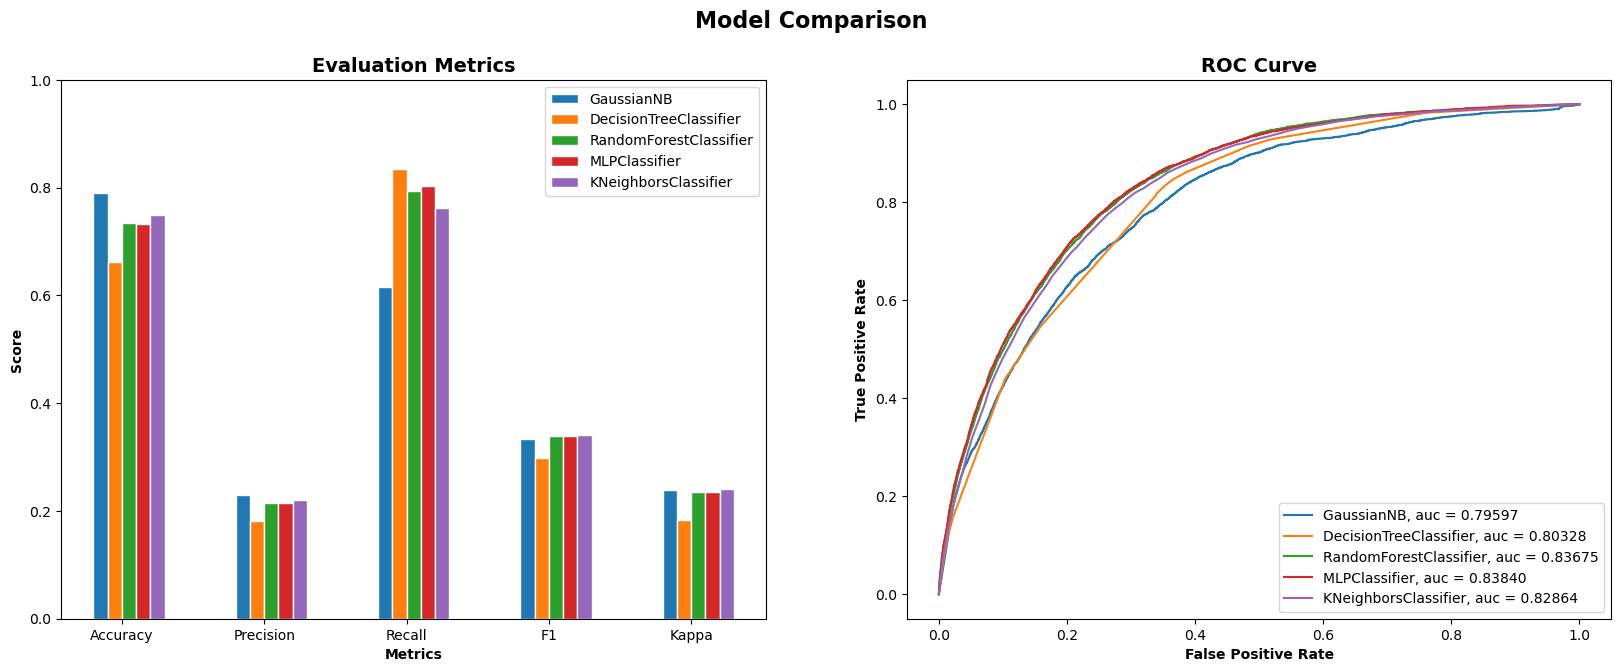

In [19]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(20)
fig.set_facecolor('white')

# set bar size
barWidth = 0.1

# Pulling scores into an array
scores = []
for estimator, eval in est_eval.items():
    score = [eval['acc'], eval['prec'], eval['rec'], eval['f1'], eval['kappa']]
    scores.append(score)

# Set position of bar on X axis
r1 = np.arange(len(score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r = [r1, r2, r3, r4, r5, r6]

# Make the plot
for x, y in est_eval.items():
    each_r = r[0]
    each_score = scores[0]
    
    # First plot
    ax1.bar(each_r, each_score, width=barWidth, edgecolor='white', label=str(x).split('(')[0])
    
    # Second plot
    # Comparing ROC Curve
    ax2.plot(y['fpr'], y['tpr'], label=str(x).split('(')[0] + ', auc = {:0.5f}'.format(y['auc']))
    
    if len(r)>1 and len(scores)>1:
        r.remove(each_r)
        scores.remove(each_score)
    else:
        quit

# Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

# Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

# Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()